# description

make the case of interpreting a DL functional model 

using data which is not structured like an (numpy) array.

instead the data is hold in a list container wrapping multiple 2-d arrays with different shape

# some setup

In [2]:
from tlmisc.utils.gpu_assignment import gpu_assignment
gpu_assignment([0])

Using TensorFlow backend.


In [3]:
import numpy as np
import keras as k
from keras.layers import *
import shap
import pandas as pd

def model_summary(model):
    
    # print structure and number of parameters
    ##########################################
    print(model.summary())

    # plot net structure
    ####################
    from keras.utils.vis_utils import plot_model
    from IPython.display import Image, display
    
    fname = 'model_plot_tmp.png'    
    plot_model(model, to_file=fname, show_shapes=True, show_layer_names=True)        
    display(Image(filename=fname))
    
    return None


# multi modal sample data

In [4]:
nobs = 100
nfeat1 = 10
nfeat2 = 5
X1 = np.random.normal(size=nobs*nfeat1).reshape((nobs,nfeat1))
X2 = np.random.normal(size=nobs*nfeat2).reshape((nobs,nfeat2))
X1 = pd.DataFrame(X1, columns = ["X1_" + str(n+1) for n in range(nfeat1)])
X2 = pd.DataFrame(X2, columns = ["X2_" + str(n+1) for n in range(nfeat2)])


y = np.random.normal(size=nobs)
print("shape X1 = %s" %str(X1.shape))
print("shape X2 = %s" %str(X2.shape))
print(X1.__class__)

shape X1 = (100, 10)
shape X2 = (100, 5)
<class 'pandas.core.frame.DataFrame'>


# functional model with multiple inputs

In [5]:
# model
actfun = "tanh"
X1_input = k.Input(shape=X1.shape[1:], name = "X1")
X1_d = Dense(5, activation = actfun)(X1_input)

X2_input = k.Input(shape=X2.shape[1:], name = "X2")
X2_d = Dense(5, activation = actfun)(X2_input)

X1X2 = concatenate([X1_d, X2_d])
output = Dense(1, activation = actfun, name = "output")(X1X2)

# initialize model
model = k.models.Model(inputs = [X1_input, X2_input], outputs=output)

# compile model
model.compile(optimizer = "nadam",
             loss = "mse", 
             metrics = ["mse"])   

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X1 (InputLayer)                 (None, 10)           0                                            
__________________________________________________________________________________________________
X2 (InputLayer)                 (None, 5)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 5)            55          X1[0][0]                         
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 5)            30          X2[0][0]                         
__________________________________________________________________________________________________
concatenat

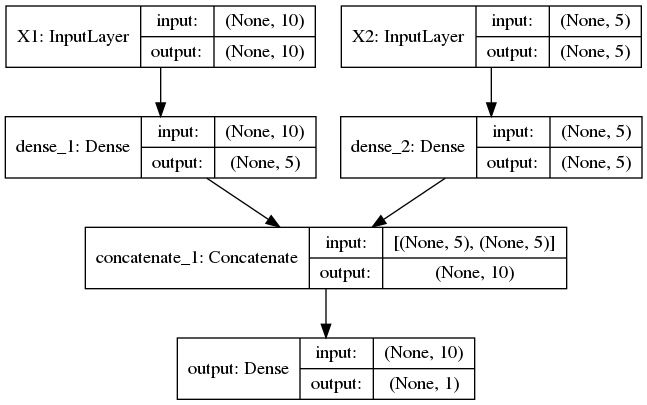

In [6]:
model_summary(model)

In [7]:
model.fit(x=[X1,X2], 
          y = y, 
          batch_size = 8, 
          epochs = 8 )

Epoch 1/8
100/100 [==============================] - 1s 6ms/step - loss: 1.3019 - mean_squared_error: 1.3019
Epoch 2/8
100/100 [==============================] - 0s 630us/step - loss: 1.2631 - mean_squared_error: 1.2631
Epoch 3/8
100/100 [==============================] - 0s 639us/step - loss: 1.2253 - mean_squared_error: 1.2253
Epoch 4/8
100/100 [==============================] - 0s 633us/step - loss: 1.1944 - mean_squared_error: 1.1944
Epoch 5/8
100/100 [==============================] - 0s 619us/step - loss: 1.1660 - mean_squared_error: 1.1660
Epoch 6/8
100/100 [==============================] - 0s 623us/step - loss: 1.1374 - mean_squared_error: 1.1374
Epoch 7/8
100/100 [==============================] - 0s 632us/step - loss: 1.1150 - mean_squared_error: 1.1150
Epoch 8/8
100/100 [==============================] - 0s 637us/step - loss: 1.0905 - mean_squared_error: 1.0905


In [8]:
# get average model prediction
pred = model.predict(x=[X1,X2])
pred1 = pred[0]
pred2 = pred[1]
avgPred = np.mean(pred)
print(avgPred)
print(pred1)
print(pred2)

0.0141185
[ 0.21859559]
[-0.4316726]


# SHAP

In [9]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
X = [X1,X2]
explainer = shap.DeepExplainer(model, data = X)
# shap_values = explainer.shap_values(X)
shap_values = explainer.shap_values([x.values for x in X])

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])



### 1st observation

In [10]:
# force plot of X1 input related features
# 1st observation
# 1st input
#shap.force_plot(explainer.expected_value, shap_values[0][0][0,:], X[0][0,:]) # numpy
shap.force_plot(explainer.expected_value, shap_values[0][0][0,:], X[0].iloc[0]) # pandas

In [11]:
# force plot of X1 input related features
# 1st observation
# 2nd input
#shap.force_plot(explainer.expected_value, shap_values[0][1][0,:], X[1][0,:]) # numpy
shap.force_plot(explainer.expected_value, shap_values[0][1][0,:], X[1].iloc[0]) # pandas

### 2nd observation

1st input domain

In [12]:
# force plot of X1 input related features
# 2nd observation
# force plot with values
# shap.force_plot(explainer.expected_value, shap_values[0][0][1,:], X[0][1,:]) # numpy
shap.force_plot(explainer.expected_value, shap_values[0][0][1,:], X[0].iloc[1]) # pandas

1nd input domain

In [13]:
# force plot of X1 input related features
# 2nd observation
# force plot with values
# shap.force_plot(explainer.expected_value, shap_values[0][1][1,:], X[1][1,:]) # numpy
shap.force_plot(explainer.expected_value, shap_values[0][1][1,:], X[1].iloc[1]) # pandas

2nd input domain, but only labels without values

In [14]:
# force plot of X1 input related features
# 2nd observation
# force plot w/o values
shap.force_plot(explainer.expected_value, shap_values[0][0][1,:]) # numpy


both input domains

but only labels without values

In [15]:
# force plot of X1 input and X2 input related features
# 2nd observation
sv_x1 = shap_values[0][0][1,:]
sv_x2 = shap_values[0][1][1,:]
sv = np.r_[sv_x1, sv_x2]

shap.force_plot(explainer.expected_value, sv)

both input domains

with custom feature names, but without values

In [16]:
feature_names = X1.columns.values.tolist() + X2.columns.values.tolist()
print(feature_names)
shap.force_plot(explainer.expected_value, sv, feature_names = feature_names)

['X1_1', 'X1_2', 'X1_3', 'X1_4', 'X1_5', 'X1_6', 'X1_7', 'X1_8', 'X1_9', 'X1_10', 'X2_1', 'X2_2', 'X2_3', 'X2_4', 'X2_5']


bot input domains

with custom feature names and values

In [17]:
features = np.r_[X[0].iloc[1], X[1].iloc[1]]
shap.force_plot(explainer.expected_value, sv, features, feature_names)